In [1]:
# The code was removed by Watson Studio for sharing.

#Introduction

In this report I will analyze distribution of pizza stores in the principal neighborhoods of Buenos Aires, and determine where the density is higher, where are located the best rated ones, and conclude the analysis with guidelines for future investors about the most appropiate locations to open a pizza store, and foresee the profiles of each neighborhood. That means locating the spots in each those neighborhoods, where there is a lack of stores, but there exist an habit of high consumption.

#Data

The data that will be used for this project will be Foursquare location data, and a geojson file of the neighborhoods of Buenos Aires, to create a Cloropleth map.
With the Foursquare data, I'll retrieve the stores, the location of them, and the rating. From the geojson file I'll get the neighborhood borders to visualize the results analysis from a cloropleth map perspective, when comparing the neighborhoods. 
From https://data.buenosaires.gob.ar/ I will retrieve each neighborhood's name, the economical districts, and specifically from https://data.buenosaires.gob.ar/dataset/mapa-de-oportunidades-comerciales-moc I will get demographic information of each neighborhood, average age, and main economical activities.



In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium  #lib to visualize maps

#import matplotlib for ploting data
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

#shapely libraby will let us calculate centroids from the polygons provided by the city goverment.
!pip install shapely
from shapely import wkt

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   1.07 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00  27.12 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  32.07 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  43.63 MB/s
    100% |████████████████████████████████| 1.5MB 417kB/s ta 0:00:01


###Get data of the neighborhoods of Buenos Aires, from a datasheet from https://data.buenosaires.gob.ar/dataset/barrios site and put it into a dataframe

In [49]:
#take the file from the project files
file_barrios = project.get_file("barrios.csv")
file_barrios.seek(0)

0

In [50]:
df_barr = pd.read_csv(file_barrios,encoding='latin-1')
#
df_barr.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


###Import shapely module to calculate centroids

In [51]:
from shapely import wkt
Neigh_lng=[]
Neigh_lat=[]
for points in df_barr['WKT']:
    g = (wkt.loads(points)).centroid.coords[0]
    Neigh_lng.append(g[0])
    Neigh_lat.append(g[1])
    


In [52]:
#Insert latitude and longitude location in dataframe
df_barr['Latitude']=Neigh_lat
df_barr['Longitude']=Neigh_lng

#rename some columns
df_barr.rename(columns={'BARRIO':'Neighborhood','COMUNA':'Borough'},inplace=True)

#Clean the borough numbers taking out the zero decimal.
df_barr.Borough.astype(str,inplace=True)
Borough_Str = []
for i in df_barr['Borough']:
    x = str(i).split('.')
    Borough_Str.append(x[0])
df_barr['Borough']=Borough_Str
#df_barr.head()

#Drop some more columns
df_barr.drop(['WKT','PERIMETRO','AREA'],axis=1,inplace=True)

In [53]:
#Lets see the dataframe how it looks
df_barr

,Neighborhood,Borough,Latitude,Longitude
0,CHACARITA,15,-34.588372,-58.454175
1,PATERNAL,15,-34.597421,-58.468665
2,VILLA CRESPO,15,-34.598834,-58.442722
3,VILLA DEL PARQUE,11,-34.604247,-58.490677
4,ALMAGRO,5,-34.609227,-58.421745
5,CABALLITO,6,-34.616825,-58.443603
6,VILLA SANTA RITA,11,-34.616193,-58.482957
7,MONTE CASTRO,10,-34.619298,-58.506581
8,VILLA REAL,10,-34.619493,-58.526039
9,FLORES,7,-34.636803,-58.458268


In [54]:
df_barr.shape

(48, 4)

###Now we'll create a map using folium module and geocode module to get the location of Buenos Aires easily

In [16]:
address1 = 'Ciudad de Buenos Aires'

geolocator1 = Nominatim()
location1 = geolocator1.geocode(address1)
latitude1 = location1.latitude
longitude1 = location1.longitude
print('The geograpical coordinate of Buenos Aires City are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Buenos Aires City are -34.6075616, -58.437076.


###Create a map of Buenos Aires city, with a blue popup in each neighborhood


In [17]:
map_barr = folium.Map(location=[latitude1, longitude1], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_barr['Latitude'], df_barr['Longitude'], df_barr['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barr)  
    
map_barr



###We could say that although neighborhoods are relatively well distributed, there are a few zones with lower density of them. Palermo neighborhood is the biggest one, northeast of the city.

##Now we will start using Foursquare's API to retireve data about venues in each neighborhood

####Foursquare credentials

In [56]:
# The code was removed by Watson Studio for sharing.

###Function to iteratively seek through each neighborhood of the dataframe df_barr

In [64]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    

    
    return(nearby_venues)

###Function to get top 100 pizza place venues of each neighborhood, within a radius of 500 metres limit

###Call of the function, getNearbyVenues

####Run the function

In [65]:
LIMIT = 100
radius = 500

ba_venues = getNearbyVenues(names=df_barr['Neighborhood'],
                                   latitudes=df_barr['Latitude'],
                                   longitudes=df_barr['Longitude'],
                                
                                  )


CHACARITA
PATERNAL
VILLA CRESPO
VILLA DEL PARQUE
ALMAGRO
CABALLITO
VILLA SANTA RITA
MONTE CASTRO
VILLA REAL
FLORES
FLORESTA
CONSTITUCION
SAN CRISTOBAL
BOEDO
VELEZ SARSFIELD
VILLA LURO
PARQUE PATRICIOS
MATADEROS
VILLA LUGANO
SAN TELMO
SAAVEDRA
COGHLAN
VILLA URQUIZA
COLEGIALES
BALVANERA
VILLA GRAL. MITRE
PARQUE CHAS
AGRONOMIA
VILLA ORTUZAR
BARRACAS
PARQUE AVELLANEDA
PARQUE CHACABUCO
NUEVA POMPEYA
PALERMO
VILLA RIACHUELO
VILLA SOLDATI
VILLA PUEYRREDON
VILLA DEVOTO
LINIERS
VERSALLES
PUERTO MADERO
MONSERRAT
SAN NICOLAS
BELGRANO
RECOLETA
RETIRO
NUÑEZ
BOCA


In [66]:
ba_venues.shape

(1085, 7)

In [67]:
ba_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CHACARITA,-34.588372,-58.454175,El Imperio de la Pizza,-34.586890,-58.454967,Pizza Place
1,CHACARITA,-34.588372,-58.454175,Fábrica de Churros Olleros,-34.586983,-58.453640,Bakery
2,CHACARITA,-34.588372,-58.454175,Albamonte Ristorante,-34.587803,-58.453075,Argentinian Restaurant
3,CHACARITA,-34.588372,-58.454175,Pizzería Santa María,-34.587492,-58.453991,Pizza Place
4,CHACARITA,-34.588372,-58.454175,Santos 4040,-34.588822,-58.449863,Theater


###Lets see how many venues per neighborhood we got from the rerquest. 

In [80]:
ba_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head(20)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
BELGRANO,100,100,100,100,100,100
SAN TELMO,100,100,100,100,100,100
SAN NICOLAS,90,90,90,90,90,90
RECOLETA,66,66,66,66,66,66
VILLA CRESPO,53,53,53,53,53,53
MONSERRAT,45,45,45,45,45,45
VILLA URQUIZA,40,40,40,40,40,40
NUÑEZ,38,38,38,38,38,38
VILLA DEVOTO,37,37,37,37,37,37


In [396]:
def getNearbyPizzaVenues(names, latitudes, longitudes, radius=500):
    venues_list1=[]
    bad_ones=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
   
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)


        results1 = requests.get(url).json()['response']['venues']
        #return('------->',results1)
        try:
            x=(results1[0]['categories'][0]['id'])
        except:
            x='Nan'
        
            
            
        # return only relevant information for each nearby venue
   
        venues_list1.append([(
            x,
            name,
            lat, 
            lng,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['name']) for v in results1])
            

            #venues_list1[0].append(results1[0]['categories'][0]['id'])
    
        #print('---->',venues_list1)
             
    pizza_venues = pd.DataFrame([item for venue_list1 in venues_list1 for item in venue_list1])
    #return(pizza_venues)

    pizza_venues.columns = ['Id','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'
                           ]
    
    return(pizza_venues)
        


###Call of the function getNearbyPizzaVenues

In [397]:
LIMIT = 100
radius = 500
search_query = 'Pizza'
pizza_venues = getNearbyPizzaVenues(names=df_barr['Neighborhood'],
                                   latitudes=df_barr['Latitude'],
                                   longitudes=df_barr['Longitude'],
                                
                                  )

In [398]:
pizza_venues

,Id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4bf58dd8d48988d1ca941735,CHACARITA,-34.588372,-58.454175,El Imperio de la Pizza,-34.586890,-58.454967,El Imperio de la Pizza
1,4bf58dd8d48988d1ca941735,CHACARITA,-34.588372,-58.454175,San Remo Pizza & Cafe,-34.587082,-58.454902,San Remo Pizza & Cafe
2,4bf58dd8d48988d1ca941735,CHACARITA,-34.588372,-58.454175,Fabrica de Pizzas,-34.588828,-58.448619,Fabrica de Pizzas
3,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,Totem Pizza,-34.598905,-58.439427,Totem Pizza
4,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,Pizza Gigante,-34.601706,-58.438929,Pizza Gigante
5,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,Pizza Crespo,-34.598273,-58.440724,Pizza Crespo
6,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,Pizza Krozz,-34.597663,-58.437704,Pizza Krozz
7,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,La Mia Pizza,-34.600014,-58.437440,La Mia Pizza
8,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,Pizzería Imperio,-34.599850,-58.439026,Pizzería Imperio
9,4bf58dd8d48988d1ca941735,VILLA CRESPO,-34.598834,-58.442722,pizzacrespo,-34.598294,-58.440558,pizzacrespo


In [403]:
pizza_anova = pizza_venues.iloc[:,0:2]
pizza_anova.drop([35,36,37,38],inplace=True)
pizza_anova.drop([62,63,64,65,66,67,68],inplace=True)

In [404]:
pizza_anova

,Id,Neighborhood
0,4bf58dd8d48988d1ca941735,CHACARITA
1,4bf58dd8d48988d1ca941735,CHACARITA
2,4bf58dd8d48988d1ca941735,CHACARITA
3,4bf58dd8d48988d1ca941735,VILLA CRESPO
4,4bf58dd8d48988d1ca941735,VILLA CRESPO
5,4bf58dd8d48988d1ca941735,VILLA CRESPO
6,4bf58dd8d48988d1ca941735,VILLA CRESPO
7,4bf58dd8d48988d1ca941735,VILLA CRESPO
8,4bf58dd8d48988d1ca941735,VILLA CRESPO
9,4bf58dd8d48988d1ca941735,VILLA CRESPO


(146, 7)

###Getting the shape of the dataframe, we can see we have 146 total venues

###Now lets see the pizza venues dataframe grouped per neighborhood, counting how many venues, and sorted in descending mode. We'll keep this dataframe to use it in later analysis.

In [95]:
pizza_neighborhood = pizza_venues.groupby(['Neighborhood']).count().sort_values(by='Venue', ascending=False)
pizza_neighborhood.head(5)
pizza_neighborhood['Venue'].values

array([20, 11, 10,  8,  8,  7,  7,  7,  6,  6,  5,  5,  4,  4,  4,  4,  3,
        3,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

###Now, using the dataframe of general venues for each neighborhood and see how many Pizza Places are per Neighborhood. We can see that 'Pizza Place' category is third, in a limited search of 100 venues 


In [81]:
ba_venues.groupby(['Venue Category']).count().sort_values(by='Venue', ascending=False).head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Café,78,78,78,78,78,78
Argentinian Restaurant,74,74,74,74,74,74
Pizza Place,68,68,68,68,68,68
Coffee Shop,47,47,47,47,47,47
Ice Cream Shop,44,44,44,44,44,44
Hotel,36,36,36,36,36,36
Bakery,31,31,31,31,31,31
BBQ Joint,28,28,28,28,28,28
Restaurant,27,27,27,27,27,27


###Now, lets see how many Pizza Places are per Neighborhood, on the dataframe about general venues of the city

In [77]:
ba_category = ba_venues[['Venue Category','Neighborhood']]
ba_pizza_categ = ba_category[ba_category['Venue Category']=='Pizza Place'].groupby(['Neighborhood']).count().sort_values(by='Venue Category', ascending=False)
ba_pizza_categ.head(5)

,Venue Category
Neighborhood,
VILLA CRESPO,8
BELGRANO,6
SAN TELMO,6
SAN NICOLAS,6
VILLA URQUIZA,3


###As here we are counting how many pizza places are per neighborhood, from a dataframe that has information about the top 100 venues per neighborhood, we can see there's a difference between this and the one we sorted from the dataframe about pizza venues only. 
In this dataframe displayed above, we can see first with 8 pizza venues Villa Crespo neighborhood, and second with 6 we have three: Belgrano, San Telmo, San Nicolas. If we go back to pizza_neighborhood dataframe, that counted pizza venues from the only pizza request, we see first San Nicolas with 20, second Montserrat with 11, third Recoleta with 10, and fourth Almagro and Villa Crespo with 8 pizza venues.
To conclude this comparison, we see that talking about pizza places in Buenos Aires, quantity isn't synonymous of quality. Althoug Villa Crespo neighborhood may not have the amount of pizza places that San Nicolas has, we clearly see that Villa Crespo has better rated ones. Anyway, San Nicolas is first in pizza_neighborhood and second in ba_pizza_categ, so we can mark it, with Villa Crespo, as the main neighborhoods to look for pizza as consumer.  

In [121]:
def getNearbyRatePizzaVenues(names, latitudes, longitudes, radius=500):
    venues_list2=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
   
        #url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            #CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)


        results1 = requests.get(url).json()["response"]['venues']       
        # return only relevant information for each nearby venue
        print('------>>>>>',results1)
"""        
        venues_list2.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['rating'],
            v['name']) for v in results1])
        #try:
        #    venues_list2.append(result['response']['venue']['rating'])
        #except:
        #    venues_list2.append('NaN')
    return(venues_list2)
"""
"""
    pizza_rate = pd.DataFrame([item for venue_list1 in venues_list1 for item in venue_list1])
    pizza_rate.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Rate']
"""   
   # return(venues_list1)

"\n    pizza_rate = pd.DataFrame([item for venue_list1 in venues_list1 for item in venue_list1])\n    pizza_rate.columns = ['Neighborhood', \n                  'Neighborhood Latitude', \n                  'Neighborhood Longitude', \n                  'Venue', \n                  'Venue Latitude', \n                  'Venue Longitude', \n                  'Venue Category',\n                  'Rate']\n"

In [122]:
LIMIT = 100
radius = 500
search_query = 'Pizza'
pizza_rated = getNearbyRatePizzaVenues(names=df_barr['Neighborhood'],
                                   latitudes=df_barr['Latitude'],
                                   longitudes=df_barr['Longitude'],
                                
                                  )

------>>>>> [{'name': 'El Imperio de la Pizza', 'location': {'address': 'Av. Corrientes 6899', 'country': 'Argentina', 'postalCode': 'C1427BPG', 'formattedAddress': ['Av. Corrientes 6899 (esq. Av. Federico Lacroze)', 'C1427BPG Buenos Aires', 'Buenos Aires C.F.', 'Argentina'], 'lat': -34.58689, 'state': 'Buenos Aires C.F.', 'cc': 'AR', 'labeledLatLngs': [{'label': 'display', 'lng': -58.454967, 'lat': -34.58689}], 'crossStreet': 'esq. Av. Federico Lacroze', 'lng': -58.454967, 'distance': 180, 'city': 'Buenos Aires'}, 'categories': [{'primary': True, 'name': 'Pizza Place', 'id': '4bf58dd8d48988d1ca941735', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_', 'suffix': '.png'}, 'pluralName': 'Pizza Places', 'shortName': 'Pizza'}], 'referralId': 'v-1536693990', 'hasPerk': False, 'id': '4befa4ef5e4aa593d54359bb'}, {'name': 'San Remo Pizza & Cafe', 'location': {'state': 'Buenos Aires', 'address': 'Av. Corrientes 6875', 'cc': 'AR', 'labeledLatLngs': [{'label': 'display', 'l

In [114]:
pizza_rated

[[('CHACARITA',
   -34.58837214424446,
   -58.454174830152155,
   'El Imperio de la Pizza',
   -34.58689,
   -58.454967,
   'El Imperio de la Pizza'),
  ('CHACARITA',
   -34.58837214424446,
   -58.454174830152155,
   'San Remo Pizza & Cafe',
   -34.58708161862193,
   -58.454901819057696,
   'San Remo Pizza & Cafe'),
  ('CHACARITA',
   -34.58837214424446,
   -58.454174830152155,
   'Fabrica de Pizzas',
   -34.58882760322861,
   -58.44861904923136,
   'Fabrica de Pizzas')],
 [],
 [('VILLA CRESPO',
   -34.59883364836629,
   -58.44272186450054,
   'Totem Pizza',
   -34.5989053006621,
   -58.43942686996836,
   'Totem Pizza'),
  ('VILLA CRESPO',
   -34.59883364836629,
   -58.44272186450054,
   'Pizza Gigante',
   -34.6017064069898,
   -58.438929319381714,
   'Pizza Gigante'),
  ('VILLA CRESPO',
   -34.59883364836629,
   -58.44272186450054,
   'Pizza Crespo',
   -34.59827275848739,
   -58.44072358274896,
   'Pizza Crespo'),
  ('VILLA CRESPO',
   -34.59883364836629,
   -58.44272186450054,
   '

In [ ]:
    #venue_id = 4fb59624e4b0b85e6ee58ba7
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    print(result['response']['venue'].keys())
    result['response']['venue']
    try:
        print(result['response']['venue']['rating'])
    except:
        print('This venue has not been rated yet.')

###In the following section we will visualize in a cloropleth map the different data we talked about

In [216]:
lati = -34.6075616 
longi = -58.437076
ba_mapa = folium.Map(location=[lati, longi],tiles='Mapbox Bright', zoom_start=12)


In [82]:
geo_file = project.get_file('barrios_de_buenos_aires.geojson')
geo_file.seek(0)
#geo_file.read()

0

In [220]:
#f7 = r'file_geo'

In [221]:
#ba_mapa.choropleth(geo_data=f7,data=df_grouped_sum,columns=['Neighborhood','Total Venues'],key_on='feature',fill_color='YlOrRd',fill_opacity=0.7,line_opacity=0.2,legend_name='Pizza')
    
#ba_mapa


###Analyze each neighborhood, in terms of proportion

In [99]:
# one hot encoding
ba_onehot = pd.get_dummies(ba_venues[['Venue Category']], prefix="", prefix_sep="")
y = ba_onehot.columns

# add neighborhood column back to dataframe
ba_onehotc['Neighborhood'] = ba_venues['Neighborhood']




# move neighborhood column to the first column
fixed_columns = [ba_onehot.columns[-1]] + list(ba_onehot.columns[:-1])
#fixed_columns = ['Neighborhood']+y# + list(ba_onehot.columns[:-1])
#print(fixed_columns)
ba_onehot = ba_onehotc[fixed_columns]
ba_onehot.head()



,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Fondue Restaurant,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Office,Opera House,Optical Shop,Outdoor Sculpture,Paintball Field,Park,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Print Shop,Pub,Racetrack,Radio Station,Record Shop,Recording Studio,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHACARITA,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHACARITA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHACARITA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHACARITA,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0

In [101]:
ba_grouped = ba_onehot.groupby('Neighborhood').mean().reset_index()
ba_grouped.head()
#ba_grouped['Pizza Place']

,Neighborhood,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Fondue Restaurant,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Outdoor Sculpture,Paintball Field,Park,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Print Shop,Pub,Racetrack,Radio Station,Record Shop,Recording Studio,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Salad Place,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Vietnamese Restaurant
0,AGRONOMIA,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.125,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.25,0.0,0.0,0.0,0.0,0.0,0.125,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.00,0.0,0.0,0.0
1,ALMAGRO,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.00,0.000,0.0,0.028571,0.0,0.028571,0.085714,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.057143,0.057143,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.00,0.028571,0.0,0.028571,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.028571,0.00,0.028571,0.028571,0.00,0.028571,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.085714,0.0,0.028571,0.0,0.028571,0.0,0.028571,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.028571,0.0,0.0,0.0,0.028571,0.

###Get the top 30 venues per nmeighborhood

In [315]:
num_top_venues = 30

for hood in ba_grouped['Neighborhood']:
    print("--->"+hood+"<---")
    temp = ba_grouped[ba_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

--->AGRONOMIA<---
                    venue  freq
0            Soccer Field  0.25
1             Snack Place  0.12
2             Sports Club  0.12
3                   Trail  0.12
4              Restaurant  0.12
5      Athletics & Sports  0.12
6           Garden Center  0.12
7   Vietnamese Restaurant  0.00
8             Opera House  0.00
9             Music Store  0.00
10            Music Venue  0.00
11        Nature Preserve  0.00
12              Nightclub  0.00
13                 Office  0.00
14        Paintball Field  0.00
15           Optical Shop  0.00
16      Outdoor Sculpture  0.00
17                   Park  0.00
18  Performing Arts Venue  0.00
19    Peruvian Restaurant  0.00
20               Pharmacy  0.00
21            Pizza Place  0.00
22             Playground  0.00
23                  Plaza  0.00
24                 Museum  0.00
25          Moving Target  0.00
26              Multiplex  0.00
27           Liquor Store  0.00
28     Israeli Restaurant  0.00
29     Italian Restaur

###Now we'll create a new dataframe and display the top 10 venues per neighborhood

In [316]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [317]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ba_grouped['Neighborhood']

for ind in np.arange(ba_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ba_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,AGRONOMIA,Soccer Field,Snack Place,Trail,Garden Center,Sports Club,Athletics & Sports,Restaurant,English Restaurant,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Veterinarian,Empanada Restaurant,Food Service,Eastern European Restaurant,Diner
1,ALMAGRO,Argentinian Restaurant,Bar,Ice Cream Shop,Café,Bus Stop,Pizza Place,Plaza,Rental Service,Mexican Restaurant,Performing Arts Venue,Coffee Shop,Market,Concert Hall,Cheese Shop,Gourmet Shop,Sandwich Place,Bakery,Indie Theater,BBQ Joint,Hardware Store
2,BALVANERA,Café,Electronics Store,Pizza Place,Fast Food Restaurant,BBQ Joint,Intersection,Arts & Crafts Store,Gym,Event Space,Food Service,Food & Drink Shop,Fondue Restaurant,Flea Market,Farmers Market,Falafel Restaurant,Veterinarian,English Restaurant,French Restaurant,Empanada Restaurant,Eastern European Restaurant
3,BARRACAS,Grocery Store,Speakeasy,Buffet,Clothing Store,Farmers Market,Veterinarian,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Falafel Restaurant,Event Space,English Restaurant,Food Truck,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Diner,Dim Sum Restaurant,Dessert Shop
4,BELGRANO,Chinese Restaurant,Pizza Place,Asian Restaurant,Coffee Shop,Café,Argentinian Restaurant,BBQ Joint,Grocery Store,Peruvian Restaurant,Restaurant,Ice Cream Shop,Sushi Restaurant,Vegetarian / Vegan Restaurant,Burger Joint,French Restaurant,Breakfast Spot,Italian Restaurant,Cocktail Bar,Pharmacy,Gym
5,BOCA,Pizza Place,Performing Arts Venue,Argentinian Restaurant,Art Gallery,Art Museum,Theater,Bus Stop,Seafood Restaurant,Farmers Market,Restaurant,English Restaurant,Fondue Restaurant,Flea Market,Fast Food Restaurant,Falafel Restaurant,Event Space,Electronics Store,Empanada Restaurant,Food Service,Eastern European Restaurant
6,BOEDO,Argentinian Restaurant,Soccer Field,Breakfast Spot,BBQ Joint,Brewery,Music Venue,Grocery Store,Ice Cream Shop,Dessert Shop,Pizza Place,Intersection,Eastern European Restaurant,Food Truck,Food Service,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Electronics Store,Farmers Market
7,CABALLITO,Bakery,Café,Plaza,Pharmacy,Pizza Place,Electronics Store,Gym,Soccer Stadium,Sporting Goods Shop,Liquor Store,Fried Chicken Joint,Market,Bistro,Restaurant,Burger Joint,Bus Stop,Empanada Restaurant,Basketball Court,Argentinian Restaurant,Vegetarian / Vegan Restaurant
8,CHACARITA,Pizza Place,Coffee Shop,Bus Stop,Bakery,Metro Station,Café,Park,Farmers Market,Beer Bar,Spanish Restaurant,Sporting Goods Shop,Bar,Bus Station,Sandwich Place,Indie Theater,Venezuelan Restaurant,Office,Train Station,Argentinian Restaurant,Theater
9,COGHLAN,Pizza Place,Argentinian Restaurant,Gym / Fitness Center,Food Service,Bus Station,Bus Stop,Café,Music Store,Bakery,BBQ Joint,Brewery,History Museum,Ice Cream Shop,English Restaurant,Empanada Restaurant,Food Truck,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant


##Group Neighborhood through k-means clustering 

In [322]:
# set number of clusters
kclusters = 5

ba_grouped_clustering = ba_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ba_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 


###Merge a new dataframe to display clusters

In [323]:
ba_merged = df_barr#.drop('Borough',axis=1)

# add clustering labels
ba_merged['Cluster Labels'] = kmeans.labels_

# merge ba_grouped with df_ba_b to add latitude/longitude for each borough
ba_merged = ba_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ba_merged # check the last columns!
ba_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,CHACARITA,15,-34.588372,-58.454175,1,Pizza Place,Coffee Shop,Bus Stop,Bakery,Metro Station,Café,Park,Farmers Market,Beer Bar,Spanish Restaurant,Sporting Goods Shop,Bar,Bus Station,Sandwich Place,Indie Theater,Venezuelan Restaurant,Office,Train Station,Argentinian Restaurant,Theater
1,PATERNAL,15,-34.597421,-58.468665,4,Wine Shop,Pizza Place,Music Venue,Diner,Veterinarian,Event Space,Food Service,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Empanada Restaurant,English Restaurant,French Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant,Dessert Shop
2,VILLA CRESPO,15,-34.598834,-58.442722,4,Pizza Place,Argentinian Restaurant,Café,Coffee Shop,Dance Studio,Sandwich Place,Gym,Breakfast Spot,Furniture / Home Store,Latin American Restaurant,Empanada Restaurant,Martial Arts Dojo,Soccer Field,Music Venue,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Beer Bar,Jewish Restaurant,Mobile Phone Shop
3,VILLA DEL PARQUE,11,-34.604247,-58.490677,1,Pharmacy,Ice Cream Shop,Argentinian Restaurant,Bakery,Pizza Place,Plaza,Cocktail Bar,Fast Food Restaurant,Café,Shopping Mall,Bookstore,Big Box Store,Mediterranean Restaurant,Italian Restaurant,Train Station,Athletics & Sports,Gym,Empanada Restaurant,Historic Site,Farmers Market
4,ALMAGRO,5,-34.609227,-58.421745,1,Argentinian Restaurant,Bar,Ice Cream Shop,Café,Bus Stop,Pizza Place,Plaza,Rental Service,Mexican Restaurant,Performing Arts Venue,Coffee Shop,Market,Concert Hall,Cheese Shop,Gourmet Shop,Sandwich Place,Bakery,Indie Theater,BBQ Joint,Hardware Store


In [324]:
# create map
map_clusters = folium.Map(location=[latitude1, longitude1], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ba_merged['Latitude'], ba_merged['Longitude'], ba_merged['Neighborhood'], ba_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###Now lets see through each cluster 

In [325]:
ba_merged.loc[ba_merged['Cluster Labels'] == 0, ba_merged.columns[[0] + list(range(4, ba_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
5,CABALLITO,0,Bakery,Café,Plaza,Pharmacy,Pizza Place,Electronics Store,Gym,Soccer Stadium,Sporting Goods Shop,Liquor Store,Fried Chicken Joint,Market,Bistro,Restaurant,Burger Joint,Bus Stop,Empanada Restaurant,Basketball Court,Argentinian Restaurant,Vegetarian / Vegan Restaurant
18,VILLA LUGANO,0,Gym,Ice Cream Shop,Dessert Shop,Argentinian Restaurant,Pharmacy,Bus Stop,Gym / Fitness Center,Bakery,Bar,Event Space,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Veterinarian,English Restaurant,Food Truck,Empanada Restaurant
25,VILLA GRAL. MITRE,0,Supermarket,Pizza Place,Plaza,Intersection,Italian Restaurant,Outdoor Sculpture,Tennis Court,Sports Club,Café,Veterinarian,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,English Restaurant,Eastern European Restaurant,Empanada Restaurant,Electronics Store,Food & Drink Shop


In [326]:
ba_cluster1 = ba_merged.loc[ba_merged['Cluster Labels'] == 1, ba_merged.columns[[0] + list(range(4, ba_merged.shape[1]))]]
ba_cluster1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,CHACARITA,1,Pizza Place,Coffee Shop,Bus Stop,Bakery,Metro Station,Café,Park,Farmers Market,Beer Bar,Spanish Restaurant,Sporting Goods Shop,Bar,Bus Station,Sandwich Place,Indie Theater,Venezuelan Restaurant,Office,Train Station,Argentinian Restaurant,Theater
3,VILLA DEL PARQUE,1,Pharmacy,Ice Cream Shop,Argentinian Restaurant,Bakery,Pizza Place,Plaza,Cocktail Bar,Fast Food Restaurant,Café,Shopping Mall,Bookstore,Big Box Store,Mediterranean Restaurant,Italian Restaurant,Train Station,Athletics & Sports,Gym,Empanada Restaurant,Historic Site,Farmers Market
4,ALMAGRO,1,Argentinian Restaurant,Bar,Ice Cream Shop,Café,Bus Stop,Pizza Place,Plaza,Rental Service,Mexican Restaurant,Performing Arts Venue,Coffee Shop,Market,Concert Hall,Cheese Shop,Gourmet Shop,Sandwich Place,Bakery,Indie Theater,BBQ Joint,Hardware Store
7,MONTE CASTRO,1,Café,Ice Cream Shop,Argentinian Restaurant,Pizza Place,Coffee Shop,Veterinarian,Event Space,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,English Restaurant,Empanada Restaurant,Food Truck,Eastern European Restaurant,Diner,Dim Sum Restaurant
10,FLORESTA,1,Argentinian Restaurant,Middle Eastern Restaurant,Supermarket,Comfort Food Restaurant,Sandwich Place,Café,Bus Stop,Plaza,Toy / Game Store,Hardware Store,Electronics Store,Farmers Market,Historic Site,History Museum,Hobby Shop,Falafel Restaurant,Event Space,English Restaurant,Empanada Restaurant,Eastern European Restaurant
12,SAN CRISTOBAL,1,Pizza Place,Ice Cream Shop,Convenience Store,Grocery Store,Furniture / Home Store,Sushi Restaurant,Sandwich Place,Japanese Restaurant,Tennis Court,Theater,Soccer Field,Gym / Fitness Center,Cultural Center,Pharmacy,Nightclub,Empanada Restaurant,Event Space,Falafel Restaurant,English Restaurant,Dim Sum Restaurant
16,PARQUE PATRICIOS,1,Ice Cream Shop,Bakery,Restaurant,Park,Empanada Restaurant,Sandwich Place,Café,Bus Stop,Burger Joint,Bar,Pizza Place,Grocery Store,Hardware Store,Fast Food Restaurant,Farmers Market,History Museum,Falafel Restaurant,Event Space,English Restaurant,Hobby Shop
19,SAN TELMO,1,Argentinian Restaurant,Bar,Café,Pizza Place,Hotel,Ice Cream Shop,Coffee Shop,Restaurant,Beer Bar,Flea Market,BBQ Joint,Tapas Restaurant,Italian Restaurant,Art Museum,Hostel,Gastropub,Vegetarian / Vegan Restaurant,Record Shop,Print Shop,Brewery
20,SAAVEDRA,1,Bakery,Pharmacy,Restaurant,Steakhouse,Market,General Entertainment,Veterinarian,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,English Restaurant,Event Space,Food Truck,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Diner
21,COGHLAN,1,Pizza Place,Argentinian Restaurant,Gym / Fitness Center,Food Service,Bus Station,Bus Stop,Café,Music Store,Bakery,BBQ Joint,Brewery,History Museum,Ice Cream Shop,English Restaurant,Empanada Restaurant,Food Truck,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant


In [327]:
ba_merged.loc[ba_merged['Cluster Labels'] == 2, ba_merged.columns[[0] + list(range(4, ba_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
44,RECOLETA,2,Café,Hotel,Plaza,Coffee Shop,Brewery,Argentinian Restaurant,Restaurant,Ice Cream Shop,Bakery,Shopping Mall,Deli / Bodega,American Restaurant,Park,Pizza Place,Bar,Science Museum,Burger Joint,Comfort Food Restaurant,Bus Stop,Juice Bar


In [328]:
ba_merged.loc[ba_merged['Cluster Labels'] == 3, ba_merged.columns[[0] + list(range(4, ba_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
46,NUÑEZ,3,BBQ Joint,Restaurant,Ice Cream Shop,Argentinian Restaurant,Gym / Fitness Center,Gym,Sports Club,Coffee Shop,Basketball Stadium,Soccer Stadium,Soccer Field,Burger Joint,Furniture / Home Store,History Museum,Playground,Pizza Place,Convenience Store,Paintball Field,Italian Restaurant,Deli / Bodega


In [329]:
ba_merged.loc[ba_merged['Cluster Labels'] == 4, ba_merged.columns[[0] + list(range(4, ba_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1,PATERNAL,4,Wine Shop,Pizza Place,Music Venue,Diner,Veterinarian,Event Space,Food Service,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Empanada Restaurant,English Restaurant,French Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant,Dessert Shop
2,VILLA CRESPO,4,Pizza Place,Argentinian Restaurant,Café,Coffee Shop,Dance Studio,Sandwich Place,Gym,Breakfast Spot,Furniture / Home Store,Latin American Restaurant,Empanada Restaurant,Martial Arts Dojo,Soccer Field,Music Venue,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Beer Bar,Jewish Restaurant,Mobile Phone Shop
6,VILLA SANTA RITA,4,Ice Cream Shop,Park,Sports Club,Bus Stop,Café,Soccer Field,BBQ Joint,Pizza Place,Home Service,Dim Sum Restaurant,Diner,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Department Store,Falafel Restaurant,Event Space,English Restaurant
8,VILLA REAL,4,Gym,Intersection,Bus Station,History Museum,Bus Stop,English Restaurant,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Veterinarian,Food Truck,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Diner,Dim Sum Restaurant
9,FLORES,4,Café,Grocery Store,Pizza Place,Coffee Shop,Metro Station,Athletics & Sports,Supermarket,Event Space,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Veterinarian,English Restaurant,Food Truck,Empanada Restaurant,Electronics Store,Eastern European Restaurant
11,CONSTITUCION,4,Café,Intersection,Bus Stop,Soccer Field,Indie Movie Theater,BBQ Joint,Grocery Store,French Restaurant,Nightclub,Plaza,Candy Store,Shopping Plaza,Hostel,Argentinian Restaurant,Bagel Shop,Farmers Market,Arcade,Food Truck,Food Service,Food & Drink Shop
13,BOEDO,4,Argentinian Restaurant,Soccer Field,Breakfast Spot,BBQ Joint,Brewery,Music Venue,Grocery Store,Ice Cream Shop,Dessert Shop,Pizza Place,Intersection,Eastern European Restaurant,Food Truck,Food Service,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Electronics Store,Farmers Market
14,VELEZ SARSFIELD,4,Argentinian Restaurant,BBQ Joint,Bus Stop,Soccer Field,Pizza Place,Dessert Shop,Food Truck,Food Service,Food & Drink Shop,Fondue Restaurant,Flea Market,Department Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,French Restaurant,English Restaurant,Empanada Restaurant,Electronics Store
15,VILLA LURO,4,Argentinian Restaurant,Ice Cream Shop,Tennis Court,Coffee Shop,Café,Pizza Place,Spanish Restaurant,Bar,Supermarket,Bakery,BBQ Joint,Gas Station,Gym,Food & Drink Shop,Flea Market,Home Service,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
17,MATADEROS,4,Soccer Field,Skate Park,Bus Stop,Café,Veterinarian,Falafel Restaurant,Food & Drink Shop,Fondue Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Event Space,Cultural Center,English Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Diner,Dim Sum Restaurant,Dessert Shop


We can see the different neighborhood profiles grouped. 
The clusters tend to coincide very well with the different habitant profile in the city. Taking into account the objective of this report, that is food places, specifically 'Pizza Places' category, we can see that:
Cluster 0 groups the neighborhood that have medim rate of food places, mixed with gyms, parks, bus stops, veterinarian, pharmacys, and others. 
Cluster 1 groups the ones that have a solid food places offer, that would be in a medium to high rate, certainly with a lot of Pizza Places, coffe stores, and ethnic food from the principal inmigrants collectivities of the city. 
Cluster 2 is formed only by Recoleta, that is the neighborhood of the historic high-catholic society, conservative and high purchasing power. But it has a high hotel rate (and we can see in its mosto common venues), that gives Recoleta one of the principal neighborhood were tourists stay. The hotel offer is huge. 
Cluster 3 is formend only by Nuñez, a highly residential neighborhood, with a lot of gym and sports offer. One of the most famous argentine soccer teams are located here(River Plate), and although it has food places offer, with the big picture, it seems to be insignificant. 
Cluster 4 is the biggest, containing the most thriving neighborhoods in terms of food places offer, bars, and brand new high quality restaurants. Although it has a few neighborhoods with the highest rate in pizza places, the distribution of pizza places in the whole cluster is irregular. 

###Get open data of Buenos Aires from the goverment's own open data site, about gastronomic places. 

In [84]:
file_data = project.get_file("establecimientos-gastronomicos.csv")
file_data.seek(0)
df_gastro = pd.read_csv(file_data)
df_gastro.head()

,periodo,long,lat,establecimiento,razon_social,calle,altura,piso-dpto,telefono,nro_registro,fecha_inscripcion,año_inscripcion,mail,web,barrio,comuna,codigo_postal,codigo_postal_argentino
0,201807,-58.434271,-34.597104,1893,MARIDANI S.R.L.,SCALABRINI ORTIZ,701,NaN,4773-2951,RL-2017-25630894- -DGCCO,2017-11-03,2017,restaurante1893@hotmail.com,NO TIENE,Villa Crespo,Comuna 15,1414,C1414DNH
1,201807,-58.372892,-34.597594,AL CARBÓN,AL CARBON S.A.,RECONQUISTA,875,NaN,4312-5603/04,16/G/2015,2015-10-07,2015,alcarbon@fibertel.com.ar,NO TIENE,Retiro,Comuna 1,1003,C1003ABQ
2,201807,-58.383569,-34.609120,ALAMEDA RESTAURANTE,Av. de Mayo 1201 S.R.L.,AV. DE MAYO,1201,NaN,4381-2859,RL-2017-04167920- -DGDYCOF,2017-02-10,2017,consultas@alameda-restaurante.com.ar,www.alameda-restaurante.com.ar,Monserrat,Comuna 1,1085,C1085ABC
3,201807,-58.371534,-34.611306,ALDO'S RESTORAN VINOTECA,Gastronómica Palermo S.A.,MORENO,372,NaN,4343-0823,RL-2018-18305233- -DGCCO,2018-06-29,2018,info@aldosvinoteca.com,www.aldosvinoteca.com,Monserrat,Comuna 1,1091,C1091AAH
4,201807,-58.411435,-34.588835,ANASAGASTI,GRUPO ANASAGASTI S.R.L.,ANASAGASTI,2067,NaN,15-4412-2487,RL-2017-26691981,2017-11-15,2017,info@anasagasti.com.ar,http://www.anasagasti.com.ar/,Palermo,Comuna 14,1425,C1425DOA


In [85]:
#let's clean it, rename some columns
df_gastro.drop(['telefono','razon_social','piso-dpto','nro_registro','fecha_inscripcion','mail','web','codigo_postal','calle','altura','codigo_postal_argentino'],inplace=True, axis=1)
Survey_Year =['07/2018']*len(df_gastro['periodo'])
df_gastro['Survey_Date'] = Survey_Year
df_gastro.drop(['periodo'],inplace=True, axis=1)
#rename, with better names and in english
df_gastro.rename(columns={'long':'Longitude','lat':'Latitude','establecimiento':'Place_Name','año_inscripcion':'Inscription_Year','barrio':'Neighborhood','comuna':'Borough'},inplace=True)
#tidy up Borough column data
Comunas_Number = []
for i in df_gastro['Borough']:
    x = re.findall('.* ([0-9]*)', i)
    Comunas_Number.append(x[0])
df_gastro['Borough']=Comunas_Number
#drop Latitude and Longitude columns, since we wont use them
df_gastro.drop(['Latitude','Longitude'],axis=1,inplace=True)

In [86]:
df_gastro.head()

,Place_Name,Inscription_Year,Neighborhood,Borough,Survey_Date
0,1893,2017,Villa Crespo,15,07/2018
1,AL CARBÓN,2015,Retiro,1,07/2018
2,ALAMEDA RESTAURANTE,2017,Monserrat,1,07/2018
3,ALDO'S RESTORAN VINOTECA,2018,Monserrat,1,07/2018
4,ANASAGASTI,2017,Palermo,14,07/2018


###Lets analyze it, looking how many pizza venues in got for each neighborhood 

In [87]:
df_gastro['Neighborhood'].value_counts()

Palermo             14
San Nicolas         13
Monserrat           13
Retiro               9
San Telmo            8
Puerto Madero        6
Recoleta             5
Balvanera            4
Almagro              3
Boedo                2
Caballito            2
Chacarita            2
Villa Crespo         2
Villa Devoto         2
Villa Urquiza        2
Paternal             1
Colegiales           1
Belgrano             1
Saavedra             1
Boca                 1
Nu\u00f1ez           1
Villa Santa Rita     1
Barracas             1
Villa Ortuzar        1
Name: Neighborhood, dtype: int64

If we compare it with the information given by foursquare's API, in seem to be very incomplete. But, we may make use of it, looking which are the neighborhoods, that for some reason, the goverment paid more attention:
Palermo, Monserrat and San Nicolas are in the top, and far from the rest. We may think it isn't casual that the three belong to the cluster 4. Fourth in the list, it comes Retiro: it also belongs to cluster 4. In the fifth places we have San Telmo, that belongs to cluster 1, but is bordering geographically with cluster 4(Monserrat at north, Constitucion at west), and it makes sense, because it is one of the neighborhoods with the highest argentine traditional food offer. 

In [355]:
count_pizzas={}
for place,i in enumerate(df_gastro['Place_Name']):   
    x = bool(re.findall('(P|p)(I|i)(Z|z){2}(A|a)',i))
    x1= bool(re.findall('(P|p)(I|i)(Z|z){2}(E|e)(R|r)(I|i)(A|a)',i))
    if x==True or x1==True:
        count_pizzas[place] = i
    


In [356]:
count_pizzas

{81: 'PIZZA ROMA', 82: 'PIZZERIA ANGELIN'}

Above we analyzed with the help of regular expressions, how many places in df_gastro, are pizza places. The result: two places, not much. But certainly is due to the limited data provided by the source. 

###Now, lets get two more data sheets, about opening and closing stores, repectively. Provided by the gooverment's open data site.

In [5]:
file_data1 = project.get_file("apertura.csv")
file_data1.seek(0)
df_aper = pd.read_csv(file_data1,sep=';')
df_aper.head()

,RUBRO,MOC_ZONAS_ID,AÑO,CUATRIMESTRE,NIVEL
0,BARES Y CAFES,161,2016,3,1
1,COMIDA AL PASO,161,2016,2,1
2,FERRETERIA Y CONSTRUCCION,161,2016,1,1
3,FERRETERIA Y CONSTRUCCION,161,2016,2,1
4,FERRETERIA Y CONSTRUCCION,161,2016,3,1


In [6]:
#Cleaning
df_aper.drop(['MOC_ZONAS_ID','CUATRIMESTRE','NIVEL'],axis=1, inplace=True)
df_aper.rename(columns={'RUBRO':'Category','AÑO':'Year'},inplace=True)

###Lets count how many openings were done in 2016, for each category

In [7]:
df_aper_2016 = df_aper[df_aper['Year']==2016]
op_2016_categ = df_aper_2016['Category'].value_counts()


###Lets count how many openings were done in 2017, for each category

In [8]:
df_aper_2017 = df_aper[df_aper['Year']==2017]
op_2017_categ = df_aper_2017['Category'].value_counts()
op_2017_categ

INDUMENTARIA                 198
SUPERMERCADOS Y ALMACENES    123
COMIDA AL PASO               118
BARES Y CAFES                 92
KIOSCOS Y LOTERIAS            91
MUSICA Y LIBRERIA             79
CARNES Y VERDURAS             76
OPTICA Y JOYERIAS             73
RESTAURANTES                  73
FERRETERIA Y CONSTRUCCION     72
FIAMBRERIAS Y DIETETICAS      67
SALUD Y COSMETICA             64
TRATAMIENTOS ESTETICOS        60
INSUMOS PARA EL HOGAR         46
PANADERIAS                    42
INSTITUCIONES DEPORTIVAS      40
VETERINARIA                   26
HELADERIAS                    12
Name: Category, dtype: int64

In [9]:
file_data2 = project.get_file("cierre.csv")
file_data2.seek(0)
df_cierre = pd.read_csv(file_data2,sep=';')
df_cierre.head()

,RUBRO,MOC_ZONAS_ID,AÑO,CUATRIMESTRE,NIVEL
0,BARES Y CAFES,4,2016,3,1
1,BARES Y CAFES,18,2016,1,1
2,BARES Y CAFES,20,2016,2,1
3,BARES Y CAFES,23,2016,2,1
4,BARES Y CAFES,24,2016,1,1


In [10]:
df_cierre.drop(['MOC_ZONAS_ID','CUATRIMESTRE','NIVEL'],axis=1, inplace=True)
df_cierre.rename(columns={'RUBRO':'Category','AÑO':'Year'},inplace=True)


In [11]:
df_cierre_2016 = df_cierre[df_cierre['Year']==2016]
close_2016_categ = df_cierre_2016['Category'].value_counts()
close_2016_categ.values

array([321, 260, 196, 158, 155, 153, 138, 132, 113,  87,  81,  79,  68,
        67,  53,  51,  25,  13])

In [12]:
df_cierre_2017 = df_cierre[df_cierre['Year']==2017]
close_2017_categ = df_cierre_2017['Category'].value_counts()
close_2017_categ

INDUMENTARIA                 163
SALUD Y COSMETICA            106
SUPERMERCADOS Y ALMACENES     85
OPTICA Y JOYERIAS             72
COMIDA AL PASO                72
FERRETERIA Y CONSTRUCCION     68
MUSICA Y LIBRERIA             66
KIOSCOS Y LOTERIAS            59
BARES Y CAFES                 48
FIAMBRERIAS Y DIETETICAS      42
INSUMOS PARA EL HOGAR         38
CARNES Y VERDURAS             33
INSTITUCIONES DEPORTIVAS      26
RESTAURANTES                  26
TRATAMIENTOS ESTETICOS        25
PANADERIAS                    21
VETERINARIA                    9
HELADERIAS                     5
Name: Category, dtype: int64

In [13]:
print("aper16:",len(op_2016_categ),"aper17:", len(op_2017_categ),"close16:",len(close_2016_categ),"close17:", len(close_2017_categ))

aper16: 18 aper17: 18 close16: 18 close17: 18


###Lets create a dataframe, and append the different series generate above about opening and closings in 2016 and 2017

In [14]:
df_16_17 = pd.DataFrame()


In [15]:
df_16_17['Open 2016']=op_2016_categ;df_16_17['Close 2016']=close_2016_categ;df_16_17['Open 2017']=op_2017_categ;df_16_17['Close 2017']=close_2017_categ

In [16]:
df_16_17

,Open 2016,Close 2016,Open 2017,Close 2017
INDUMENTARIA,413,321,198,163
SALUD Y COSMETICA,326,260,64,106
SUPERMERCADOS Y ALMACENES,308,196,123,85
OPTICA Y JOYERIAS,292,153,73,72
FERRETERIA Y CONSTRUCCION,283,158,72,68
MUSICA Y LIBRERIA,272,155,79,66
COMIDA AL PASO,268,138,118,72
KIOSCOS Y LOTERIAS,249,132,91,59
CARNES Y VERDURAS,200,67,76,33
FIAMBRERIAS Y DIETETICAS,195,87,67,42


###Now lets select the categories we are interested in:related to food and restaurants

In [17]:
parse_categ_yrs = df_16_17.transpose()

In [18]:
df_categ_yrs = parse_categ_yrs[['COMIDA AL PASO','BARES Y CAFES','RESTAURANTES','HELADERIAS']]
#df_categ_yrs
df_categ_yrs.rename(columns={'COMIDA AL PASO':'Fast Food','BARES Y CAFES':'Bars and Coffe shops','RESTAURANTES':'Restaurants','HELADERIAS':'Ice_cream Venue'},inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [19]:
df_categ_yrs

,Fast Food,Bars and Coffe shops,Restaurants,Ice_cream Venue
Open 2016,268,157,148,53
Close 2016,138,113,81,13
Open 2017,118,92,73,12
Close 2017,72,48,26,5


In [20]:
#food_yrs = df_categ_yrs.transpose()

In [21]:
#food_yrs

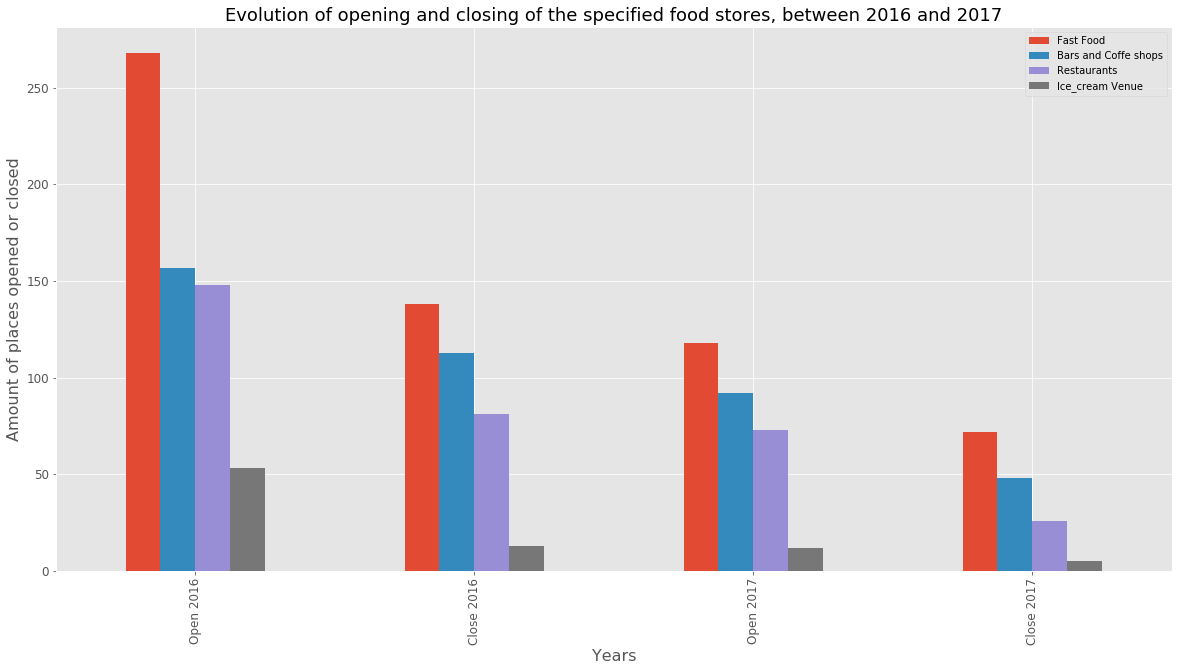

In [23]:
#fast_food = food_yrs.loc['COMIDA AL PASO',:]
df_categ_yrs.plot(kind='bar', 
             #alpha=0.25, # 0-1, default value a= 0.5
             stacked=False,
             figsize=(20, 10),
             fontsize=12
            )
plt.title('Evolution of opening and closing of the specified food stores, between 2016 and 2017',fontsize=18)
plt.xlabel('Years',fontsize=16)
plt.ylabel('Amount of places opened or closed',fontsize=16)
plt.show()

In this line plot we can see clearly, how evolved the opening and closing through 2016 and 2017. We can see that in 2016 opened much more venues than in 2017, but in 2017 the closing was much less. On the other hand, the ratio opening/closing between 2016 and 2017, shows us a bigger difference in 2016 versus 2017. 
Openings in 2017 didn't repose the quantity that closed in 2016. Although we displayed the evolution of food items, we should see in more detail Fast Food and Restaurants(See labels). If we take Fast Food item, that would be the more apropriated for Pizza Places, we can see a huge opening, in relation with other items, and in 'Close 2016', 'Open 2017' and 'Close 2017' although still first, the relationship is shortened. 
To sum up, we can see that 2016 opened with good perspectives, but it seems that in 2017, they cooled down, but still the openings 